# Today you are a **Machine Learning Ops Engineer** at **Nest Security Cameras Division**! 
## The cameras shipped by your division are used for facial detection and authentication (against intruders) and to allow access to authorized personnel.
## However, with the advent of COVID, people now turn up with face masks and the face detection algorithm that worked so far is NOT working anymore.

##**This exercise prepares you for "Project Ideation" which can then be used to build scripts towards your ML Pipelines.**

###Your task today is to start from the pre-trained Face detection model [MTCNN](https://machinelearningmastery.com/how-to-perform-face-detection-with-classical-and-deep-learning-methods-in-python-with-keras/) that detects only 5 facial landmarks (corresponding to 2 eyes, 1 nose, 2 mouth landmarks) and transform it to a 68 point facial landmark detection system by some degree of retraining and fine tuning. Your main deliverables to your manager are:

## 1. Transform facial detection from 5 landmarks to 68 landmarks for masked faces data set. This is a retraining exercise.
## 2. ML monitoring for production data using appropriate metrics to detect if faces are NOT getting appropriately detected (owing to variations in angles and psoture of people in front of camera.

For further eading and resources on facial detection algorithms please check the sources:

[1] [Face detection with OpenCV and deep learning](https://www.pyimagesearch.com/2018/02/26/face-detection-with-opencv-and-deep-learning/)

[2] [What does a face detection neural network look like](https://towardsdatascience.com/face-detection-neural-network-structure-257b8f6f85d1)

[3] [Face Detection Model](https://towardsdatascience.com/mtcnn-face-detection-cdcb20448ce0)


[4] [Face Landmark Detection with Pytorch](https://towardsdatascience.com/face-landmarks-detection-with-pytorch-4b4852f5e9c4)

##This assignment uses Pytorch Library for the Deep :earning Face Detection modules.

## Start by connecting your GDrive to Colab and checking availabiliy of required files!

In [ ]:
# First lets connect the Gdrive that contains the data
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Next, migrate to the week_2_Live folder

In [ ]:
import os
# The path below should point to the directory containing this notebook and the associated utility files
# Change it if necessary
os.chdir('/content/drive/MyDrive/MLOps_Creation/week_2_live')
!ls

 face_landmarks.pth
 ibug_300W_large_face_landmark_dataset
 Masked_faces
 ML_monitor_1.jpg
 photo.jpg
 __pycache__
 t_model.py
 wandb
'Week_2_Live_Assignment: Face_Detection_with_Masks.ipynb'
'Week_2_Live_Solution: Face_Detection_with Masks.ipynb'


# Ensure you have the following files listed in your current working folder. Restart the colab other wise, since you will NOT be able to complete if all the files are not present.

* face_landmarks.pth
* Masked_faces
* t_model.py
* Week_2_Live_Assignment: Face_Detection_with Masks.ipynb

# Task 0: Getting familiar with the problem
Lets start by getting some idea of the Problem space by using your own picture!
##[STUDENTS SHOULD TRY THIS OUT ON THEIR OWN]

In [ ]:
import imutils
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

# If you are on zoom calls, disable your video and only then run the cell below.
The following cell starts the webcam!

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

## Click 'Capture' to make photo using your webcam. Try to obscure your face to test the algorithm (turn to the side, hide your face etc.)

In [ ]:
image_file = take_photo()

<IPython.core.display.Javascript object>

Read, resize and display the image. 

400 300


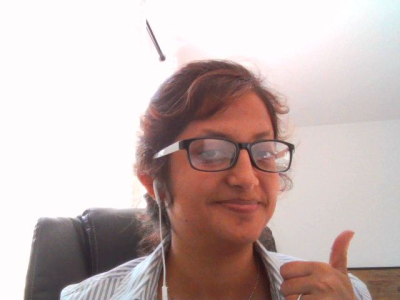

In [ ]:
#image = cv2.imread(image_file, cv2.IMREAD_UNCHANGED)
image = cv2.imread(image_file)

# resize it to have a maximum width of 400 pixels
image = imutils.resize(image, width=400)
(h, w) = image.shape[:2]
print(w,h)
cv2_imshow(image)

## Next step is to use a face detection model to detect faces in the image you just took!


# **Task 1 [Instructor Led]**: Analyze a pre-deployed ML solution.
Let us try the MTCNN algorithm on your image first. MTCNN is the the algorithm that was already shipped with the Nest Cameras. 
To learn more about MTCNN algorithm refer to the blog [Robust Face Detection with MTCNN](https://towardsdatascience.com/robust-face-detection-with-mtcnn-400fa81adc2e)

Most of the cells are pre-populated. 
### **Your task is to analyze the nature and format of the face predictions.**

In [ ]:
! pip install mtcnn

     |████████████████████████████████| 2.3 MB 7.7 MB/s 


In [ ]:
import mtcnn
import matplotlib.pyplot as plt
# print version
print(mtcnn.__version__)

0.1.0


In [ ]:
import matplotlib.pyplot as plt
pixels = plt.imread(image_file)


## Next, we apply mtcnn on the image and print the bounding boxes!

MTCNN() function is used to apply mtcnn and detect_faces is used to draw bouding box around the image. For reference see https://github.com/ipazc/mtcnn


In [ ]:
 detector = mtcnn.MTCNN()
 faces = detector.detect_faces(pixels) #'faces' represents the prediction of face bounding box and 5 landmarks!


In [ ]:
def draw_facebox_im(data, result_list):
 # plot the image
  plt.imshow(data)
  # get the context for drawing boxes
  ax = plt.gca()
  # plot each box
  for result in result_list:
  # get coordinates
    x, y, width, height = result['box']
    # create the shape
    rect = plt.Rectangle((x, y), width, height, fill=False, color='red')
    # draw the box
    ax.add_patch(rect)
    print("Predicted bbox=",x,y,width, height)
    for key, value in result['keypoints'].items():
      # create and draw dot
      
      dot = plt.Circle(value, radius=5, color='red')
      ax.add_patch(dot)
  # show the plot
  plt.show()

Predicted bbox= 271 161 172 228


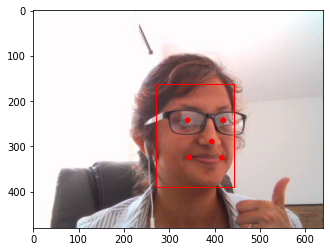

In [ ]:
# Now we visulaize the output of the MTNN algorithm on the capstured image
draw_facebox_im(pixels, faces)

In [ ]:
# Next, analyze the format of the predictions from MTCNN. 
faces

[{'box': [271, 161, 172, 228],
  'confidence': 0.9999933242797852,
  'keypoints': {'left_eye': (341, 242),
   'mouth_left': (344, 324),
   'mouth_right': (416, 325),
   'nose': (394, 289),
   'right_eye': (419, 242)}}]

## Try the above tasks a few times by posing differently and learn about the format in which the landmarks are getting stored (the output format).

# **Question (Discuss): How would you expand the seame output format for more facial landmarks? Write down your thoughts in this cell.**

# **Task 2: Online ML Monitoring over a NEW batch of production data (unannotated)**.
Now, we start looking at masked images and the outcome of MTCNN on transformed (zoomed, cropped etc.)
## We will analyze the performance of MTCNN (pre-trained) on an unannotated batch of masked faces in the Folder 'Masked_faces'.

In [ ]:
import torch
from torchvision import datasets, transforms

## Now let us apply transformations to each image to analyze resilience of MTCNN on cropping, rotated and zoomed images.

### Use the transforms.Compose() command as shown in https://pytorch.org/vision/stable/transforms.html

In [ ]:
#WRITE CODE TO TRANSFORM THE IMAGE USING THE trans.Compose() COMMAND TO ACHIEVE THE FOLLOWING
# RANDOM ROTATION OF 40%
# RANDOM RESIZED CROP TO 224 
# TRANSFORM THE IMAGE TO TENSOR (images in [0,1] range)
t_transforms = transforms.Compose(##Enter code here############) 
num=20

In [ ]:
#Next, we invoke the Pytorch data loader
data = datasets.ImageFolder('./Masked_faces/', transform=t_transforms)
dataloader = torch.utils.data.DataLoader(data, batch_size=num)

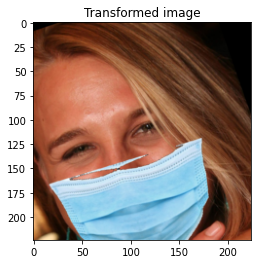

In [ ]:
#Run this cell 3-5 times to observe the random transformations applied to each image
for batch in dataloader: # Consider a batch of 1 images at a time
    images, _= batch
    #Lets get an idea of the 
    dat = images[1].cpu().detach()
    plt.imshow(dat.permute(1, 2, 0))
    plt.title('Transformed image')
    break

In [ ]:
%pip install wandb -q
import wandb
wandb.login()

     |████████████████████████████████| 1.7 MB 9.8 MB/s 
     |████████████████████████████████| 97 kB 6.6 MB/s 
     |████████████████████████████████| 180 kB 48.9 MB/s 
     |████████████████████████████████| 139 kB 48.9 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Next, lets monitor the performance of the detection on Weights and Biases.
# Initialize a new run (like you did in your offline assignment) using wandb.init command and monitor Bounding Box confidence in wandb.

# Complete the cell below to successful initialize and log a WANDB run.

(224, 224, 3)
For image 0 Confidence =0


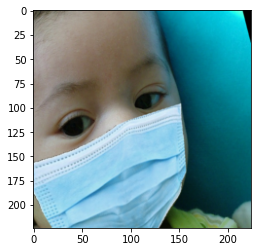

(224, 224, 3)
For image 1 Confidence = 0.9973629117012024
Predicted bbox= 7 12 155 159


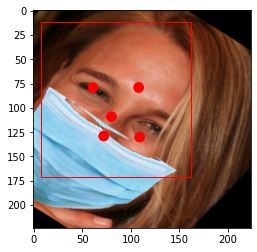

(224, 224, 3)
For image 2 Confidence =0


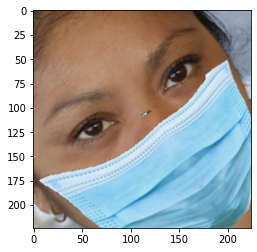

(224, 224, 3)
For image 3 Confidence = 0.9999203681945801
Predicted bbox= 38 39 134 150


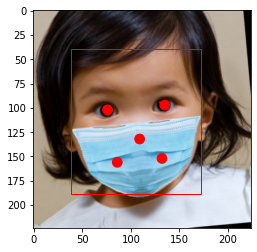

(224, 224, 3)
For image 4 Confidence =0


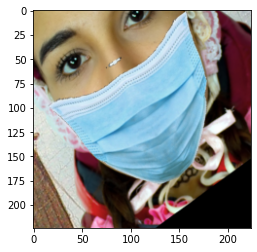

(224, 224, 3)
For image 5 Confidence = 0.9436626434326172
Predicted bbox= 49 44 175 228


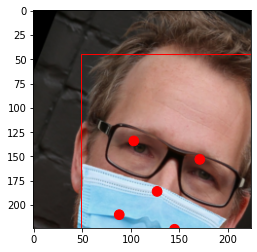

(224, 224, 3)
For image 6 Confidence = 0.9995793700218201
Predicted bbox= 45 20 149 170


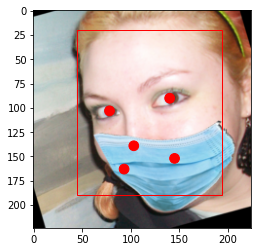

(224, 224, 3)
For image 7 Confidence = 0.9999161958694458
Predicted bbox= -6 -10 205 222


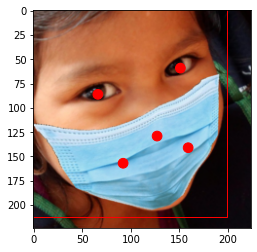

(224, 224, 3)
For image 8 Confidence =0


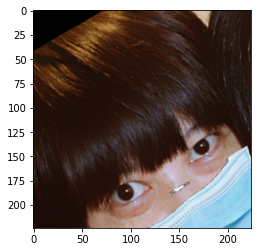

(224, 224, 3)
For image 9 Confidence =0


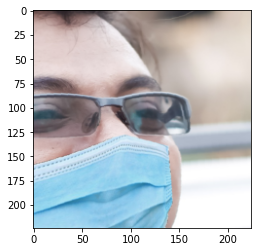

(224, 224, 3)
For image 10 Confidence = 0.9999556541442871
Predicted bbox= 10 -4 191 228


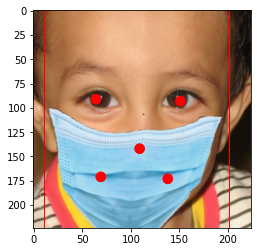

(224, 224, 3)
For image 11 Confidence =0


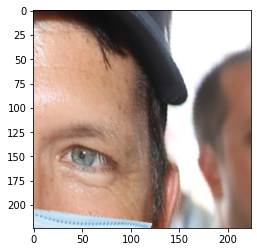

(224, 224, 3)
For image 12 Confidence = 0.9996469020843506
Predicted bbox= 53 25 136 161


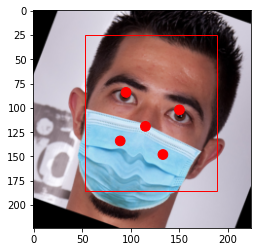

(224, 224, 3)
For image 13 Confidence =0


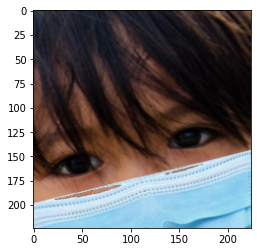

(224, 224, 3)
For image 14 Confidence = 0.9999972581863403
Predicted bbox= 14 57 165 185


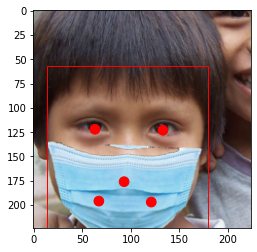

(224, 224, 3)
For image 15 Confidence = 0.9930447936058044
Predicted bbox= -16 0 191 249


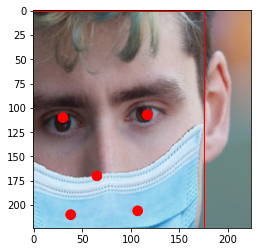

(224, 224, 3)
For image 16 Confidence = 0.8643156886100769
Predicted bbox= 20 -31 163 156


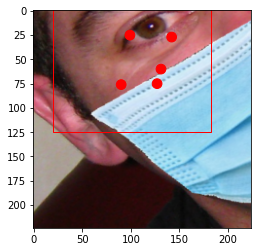

(224, 224, 3)
For image 17 Confidence = 0.9994230270385742
Predicted bbox= 44 51 133 142


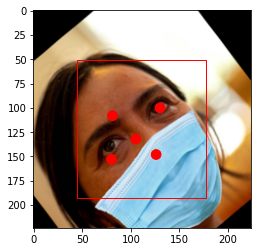

(224, 224, 3)
For image 18 Confidence = 0.9918645620346069
Predicted bbox= 46 58 131 165


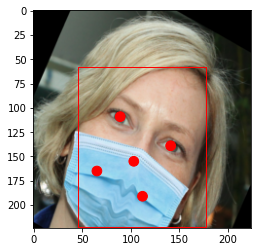

(224, 224, 3)
For image 19 Confidence = 0.9995989203453064
Predicted bbox= 42 0 154 173


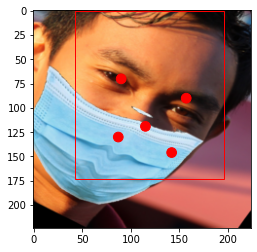

In [ ]:
# Next run bounding box and facial landmark detection on all images in batches
# Monitor the confidence of bounding box in Weights and Biases!
######WRITE CODE HERE TO INITIATIZE A WANDB RUN
### Include an "experiment_name" and wandb.init() command (SIMILAR TO THE OFFLINE ASSIGNMENT)

#############END OF CODE ENTRY########################
det_faces=[]
confidence=0
for i in range(num):
  
  for batch in dataloader:
    images, _= batch
    dat = images[i].cpu().detach()
    f_img=dat.permute(1, 2, 0).numpy()
    break
  print(np.shape(f_img))
  face=detector.detect_faces(f_img*255)
  if len(face)==0:
    print("For image", i, "Confidence =0")
  else:
      for result in face:
         print("For image", i, "Confidence =",result['confidence'])
         confidence=result['confidence']
  draw_facebox_im(f_img, face)
  # Use the "wandb.log()"" function TO LOG the 'Epoch' and 'BBox confidence' as a monitoring metric in WANDB
  #Only single command entry goes here followed by running this cell.
  


![picture](https://drive.google.com/uc?id=1JxhU0J4AtHnaMkYYSJpbbm1tLGrFrqum)

# You should see monitor plots as shown above in **Weights and Biases** panel. We can also see exactly the images that resulted in 0 or low confidences. Thus, there is a need to modify the algorithm to include more facial landmarks.

# **Task 3: New ML Model: ML Versioning.**

## Now that we have analyzed the MTCNN version of the deployed model is not effective on masked images, we plan to roll out a new model that detects 68 point facial landmark detection algorithm based on:
https://towardsdatascience.com/face-landmarks-detection-with-pytorch-4b4852f5e9c4

In [ ]:
#Import the Libraries
import matplotlib.image as mpimg

In [ ]:
#This data set will be used to train and test the facial landmark algorithm
%%capture
if not os.path.exists('./ibug_300W_large_face_landmark_dataset'):
    !wget http://dlib.net/files/data/ibug_300W_large_face_landmark_dataset.tar.gz
    !tar -xvzf 'ibug_300W_large_face_landmark_dataset.tar.gz'    
    !rm -r 'ibug_300W_large_face_landmark_dataset.tar.gz'

## Lets, first visualize the dataset

Number of facial landmarks= 68


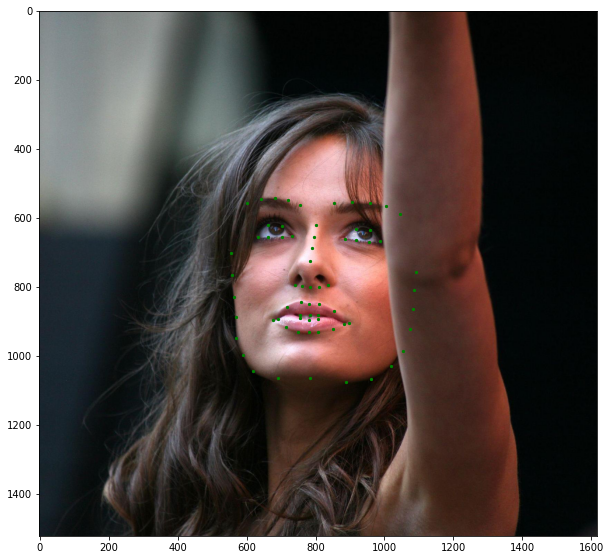

In [ ]:
# THIS IS CELL 10
file = open('ibug_300W_large_face_landmark_dataset/helen/trainset/100032540_1.pts')
points = file.readlines()[3:-1]

landmarks = []

for point in points:
    x,y = point.split(' ')
    landmarks.append([np.floor(float(x)), np.floor(float(y[:-1]))])

landmarks = np.array(landmarks)


print("Number of facial landmarks=",len(landmarks))

plt.figure(figsize=(10,10))
plt.imshow(mpimg.imread('ibug_300W_large_face_landmark_dataset/helen/trainset/100032540_1.jpg'))
plt.scatter(landmarks[:,0], landmarks[:,1], s = 5, c = 'g')
plt.show()

## Next, lets create helper functions and a Class for facial landmark detection

In [ ]:
from torch.utils.data import Dataset
import xml.etree.ElementTree as ET 
from PIL import Image
import torchvision.transforms.functional as TF
import random
from math import *

In [ ]:
class Transforms():
    def __init__(self):
        pass
    
    def rotate(self, image, landmarks, angle):
        angle = random.uniform(-angle, +angle)

        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))], 
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = imutils.rotate(np.array(image), angle)

        landmarks = landmarks - 0.5
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5
        return Image.fromarray(image), new_landmarks

    def resize(self, image, landmarks, img_size):
        image = TF.resize(image, img_size)
        return image, landmarks

    def color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.3, 
                                              contrast=0.3,
                                              saturation=0.3, 
                                              hue=0.1)
        image = color_jitter(image)
        return image, landmarks

    def crop_face(self, image, landmarks, crops):
        left = int(crops['left'])
        top = int(crops['top'])
        width = int(crops['width'])
        height = int(crops['height'])

        image = TF.crop(image, top, left, height, width)

        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return image, landmarks

    def __call__(self, image, landmarks, crops):
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks, crops)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        image, landmarks = self.color_jitter(image, landmarks)
        image, landmarks = self.rotate(image, landmarks, angle=10)
        
        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks

In [ ]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, transform=None):

        tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
        root = tree.getroot()

        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform
        self.root_dir = 'ibug_300W_large_face_landmark_dataset'
        
        for filename in root[2]:
            self.image_filenames.append(os.path.join(self.root_dir, filename.attrib['file']))

            self.crops.append(filename[0].attrib)

            landmark = []
            for num in range(68):
                x_coordinate = int(filename[0][num].attrib['x'])
                y_coordinate = int(filename[0][num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmark)

        self.landmarks = np.array(self.landmarks).astype('float32')     

        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image = cv2.imread(self.image_filenames[index], 0)
        landmarks = self.landmarks[index]
        
        if self.transform:
            image, landmarks = self.transform(image, landmarks, self.crops[index])

        landmarks = landmarks - 0.5

        return image, landmarks

dataset = FaceLandmarksDataset(Transforms())

torch.Size([1, 224, 224])


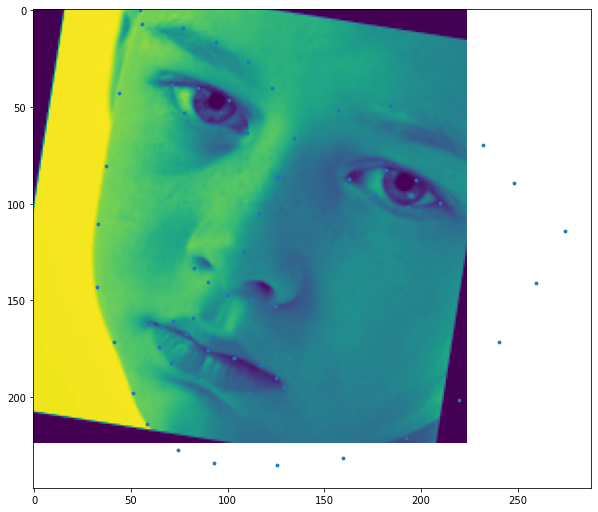

In [ ]:
n_i=1 # change n_i to visualize results on few examples of training data
image, landmarks = dataset[n_i]
print(np.shape(image))
landmarks = (landmarks + 0.5) * 224
plt.figure(figsize=(10, 10))
plt.imshow(image.numpy().squeeze());
plt.scatter(landmarks[:,0], landmarks[:,1], s=8);


In [ ]:
landmarks

tensor([[ 5.4695e+01, -1.5612e-01],
        [ 4.3934e+01,  4.2797e+01],
        [ 3.7070e+01,  8.0272e+01],
        [ 3.2852e+01,  1.1055e+02],
        [ 3.2362e+01,  1.4293e+02],
        [ 4.1062e+01,  1.7168e+02],
        [ 5.1216e+01,  1.9761e+02],
        [ 5.8306e+01,  2.1393e+02],
        [ 7.4507e+01,  2.2711e+02],
        [ 9.2704e+01,  2.3401e+02],
        [ 1.2551e+02,  2.3507e+02],
        [ 1.5957e+02,  2.3126e+02],
        [ 1.9210e+02,  2.2112e+02],
        [ 2.1949e+02,  2.0156e+02],
        [ 2.4044e+02,  1.7135e+02],
        [ 2.5940e+02,  1.4084e+02],
        [ 2.7420e+02,  1.1424e+02],
        [ 5.5594e+01,  7.0847e+00],
        [ 7.7116e+01,  8.9223e+00],
        [ 9.4167e+01,  1.6655e+01],
        [ 1.1034e+02,  2.6787e+01],
        [ 1.2292e+02,  4.0416e+01],
        [ 1.5722e+02,  5.1349e+01],
        [ 1.8390e+02,  4.9426e+01],
        [ 2.0827e+02,  5.5765e+01],
        [ 2.3197e+02,  6.9609e+01],
        [ 2.4816e+02,  8.9380e+01],
        [ 1.3414e+02,  6.600

## Notice now that the new facial landmark detection algorithm has a different data format ("landmarks" vs. "faces"). This is a common occurance to find different formats of data output when we are trying to modify to a new codebase.
## The facial landmark algorithm has a sample data format in file 'ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml' used above. 

# **Question (Discuss): How can you modify the data format of this 68-landmark detection algorithm to infer "confidence" of detection? How can the two data formats be made similar to each other?**

Enter your findings here:

## Next, we can either use the pre-trained facial landmark model or fine tune it.
### Step 1: Read new data to test the pre-trained 68-landmark detection model.

## We use random_split function from pytorch is to split "dataset" such that 10% is validation and remaining is training data. For reference on usage see https://pytorch.org/docs/stable/data.html
## Note: **Please dont use train_test_split from sklearn here since the data is in a different format. Use the Pytorch utilities instead for the splitting.**

In [ ]:
# Split 'dataset' into validation and train sets (train_dataset, valid_dataset)
# LENGTH OF VALIDATION SET IS 10% OF THE DETESET
# WRITE CODE TO USE RANDOM_SPLIT FROM TORCH.UTILS.DATA FROM ABOVE LINK TO SPLIT THE DATA 

train_dataset , valid_dataset=None
# Next, Write code to PRINT THE LENGTH OF VALIDATION SET AND TRAINING SET HERE


#############End Code Here###############################

# Next, we shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=4)

The length of Train set is 6000
The length of Valid set is 666


In [ ]:
# # The MOdel training file is 't_model.py'. To monitor training, WANDB has to be initialized in 't_model.py'
from t_model import *
PATH='./'

In [ ]:
!ls

 face_landmarks.pth
 ibug_300W_large_face_landmark_dataset
 Masked_faces
 ML_monitor_1.jpg
 photo.jpg
 __pycache__
 t_model.py
 wandb
'Week_2_Live_Assignment: Face_Detection_with_Masks.ipynb'
'Week_2_Live_Solution: Face_Detection_with Masks.ipynb'


## Step 2: Test on new data.
## There are 2 options to use t_model.py
* return_pre_trained_network(): That returns the pre-trained model
* landmark_train(PATH, train_loader, valid_loader): That fine tunes the algorithm on new data. The settings are for 3 epochs and 20 steps per epochs. This can be manually changed in the file 't_model.py'

#We start with return_pre_trained_network() in CELL 54 below

In [ ]:
#THIS IS CELL 54
best_network=return_pre_trained_network()

In [ ]:
#This function draws landmarks on the faces
def draw_face_landmarks(img,predictions):
  plt.imshow(img.cpu().numpy().transpose(1,2,0).squeeze())
  plt.scatter(predictions[0,:,0], predictions[0,:,1], c = 'r', s = 5)
  


## Next, predict on some images from the new data set. This step can take some time! 

torch.Size([8, 1, 224, 224])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Total number of test images: 666
Elapsed Time : 24.679534673690796


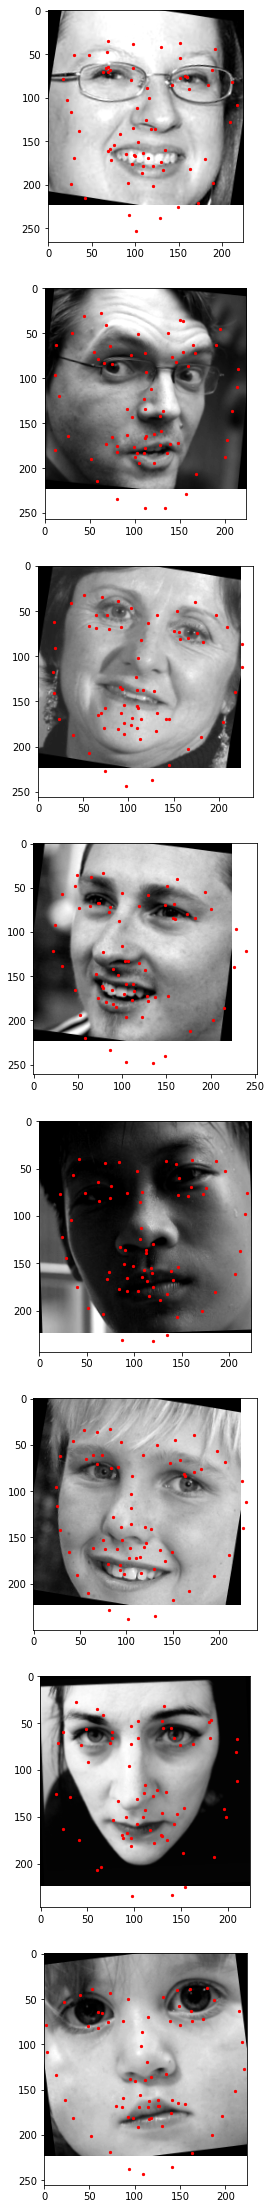

In [ ]:
# This cell helps to train and test on a few images.
import time
start_time = time.time()

with torch.no_grad():

    #Load the best save model from the previous state
    best_network.cuda()
    best_network.load_state_dict(torch.load(PATH+'face_landmarks.pth')) 
    best_network.eval()
    
    images, landmarks = next(iter(valid_loader))
    
    images = images.cuda()
    landmarks = (landmarks + 0.5) * 224
    print(np.shape(images))
    predictions = (best_network(images).cpu() + 0.5) * 224
    predictions = predictions.view(-1,68,2)
        
    plt.figure(figsize=(10,40))
    #print(predictions.shape)
    for img_num in range(8):
        plt.subplot(8,1,img_num+1)
        plt.imshow(images[img_num].cpu().numpy().transpose(1,2,0).squeeze(), cmap='gray')
        plt.scatter(predictions[img_num,:,0], predictions[img_num,:,1], c = 'r', s = 5) #Predictions are in red
        #plt.scatter(landmarks[img_num,:,0], landmarks[img_num,:,1], c = 'g', s = 5)# Actual landmarks are in green

print('Total number of test images: {}'.format(len(valid_dataset)))

end_time = time.time()
print("Elapsed Time : {}".format(end_time - start_time)) 

## Notice here that some landmarks are off! Thus, there is a need to retrain the model!

# **Task 4: Fine tune new ML model on new data**
Finally we will apply the new model on the 'Masked face' data set to observe the results of facual landmark detection on this new, unannotated data set now.
## Also apply ML monitoring to detect confidence of facial detection. You may need to coin your new metric for confidence here!


In the cell below, use the "transforms.Compose" to return pre-processed transformations into pre-process. Use this page for reference https://pytorch.org/vision/stable/transforms.html


In [ ]:
# We need to convert images to grayscale to stay compatible with the landmark prediction model
#WRITE CODE TO TRANSFORM THE IMAGE IN THE FOLLOWING FORMAT HERE:
  # CONVERT TO GRAYSCALE WITH 1 CHANNEL (Grayscale)
  # RANDOM ROTATION OF 20% (RandomRotation)
  # RANDOM RESIZED CROP TO 224 (RandomResizedCrop)
  # TRANSFORM THE IMAGE TO TENSOR (TOTENSOR())
#pre_process=transforms.Compose(####Enter code here####)
pre_process = transforms.Compose(
       [transforms.Grayscale(num_output_channels=1),
        transforms.RandomRotation(20),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor()])

# Step 1: We test the pre-trained model on the "Masked Faces" dataset.

In [ ]:
# Next run bounding box and facial landmark detection on all images, lets visualize some outcomes

num=20
new_data=datasets.ImageFolder('./Masked_faces/', transform=pre_process)
new_dataloader = torch.utils.data.DataLoader(new_data, batch_size=num)
images, labels  = iter(new_dataloader).next()


## **Reuse the following cell in Step 2 to visualize performance of fine-tuned model on Masked Faces dataset.**

(20, 68, 2)


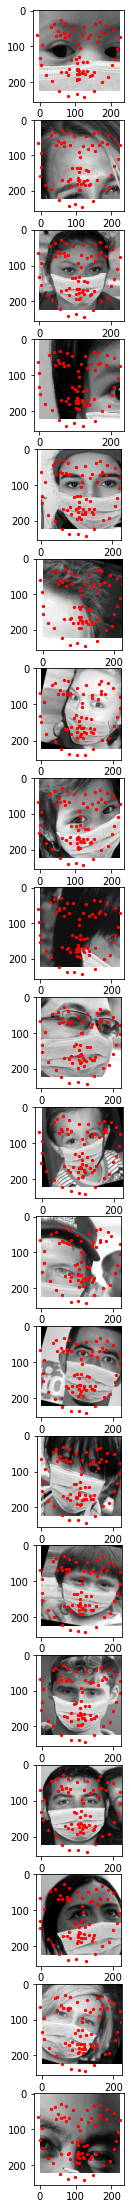

In [ ]:
#This is the cell to be reused!
images, _  = iter(new_dataloader).next()
images=images.cuda()
predictions =(best_network(images).cpu() + 0.5) * 224
predictions = predictions.view(-1,68,2).detach().numpy()
print(predictions.shape)

plt.figure(figsize=(10,40))
for img_num in range(num):
    plt.subplot(num,1,img_num+1)
    plt.imshow(images[img_num].cpu().numpy().transpose(1,2,0).squeeze(), cmap='gray')
          #print(predictions[0,:,0].detach().numpy())
    plt.scatter(predictions[img_num,:,0], predictions[img_num,:,1], c = 'r', s = 5) #Predictions are in red
    
  

## Notice the predictions are not very accurate (since not fine tuned model) but we still detect faces in cropped and zoomed images, which is what we needed!

# Now we will repeat the latter steps in Task 3 (from cell 54) that involves using 't_model.py' but with the new train and validation datasets to get more accurate detections.

## **The following cell will take about 15-20 mins to complete!**

In [ ]:
# The command to initialize training using t_model.py
# This command will take time to complete the training.
best_network=landmark_train(PATH, train_loader, valid_loader) # This is the command to retrain (transfer learning) the model.

(20, 68, 2)


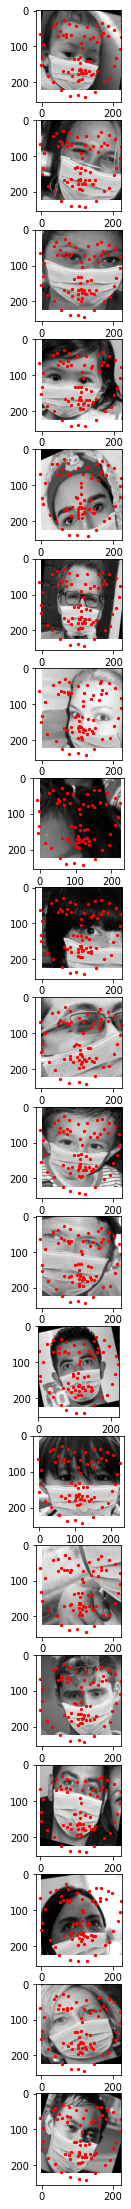

In [ ]:
#Next, display performance of the trained "best network" on the "Masked Faces dataset" by resuing code from Task 4 step 1 above.

## Notice prediction of Facial landmarks has now improved! Thus, as new data arrives, we can keep improving the ML model versions.

# **Task 5: Online Monitoring for new ML Model.**

We present one such option for reporting "detection confidence" as a fraction of 68 landmarks that are detected within the image region. 
##So if landmarks fall outside the [224x224] pixel area, that means there is low confidence for these points. We are only interested in landmark points with high confidence that lie within the image region. A higher fraction implies a higher degree of confidence in face detection.

## **Extra Credit: If you have ideas for a new metric for online monitoring, please discuss in class and add it here.**

In [ ]:
#WRITE CODE TO INITIALIZE A NEW WANDB RUN HERE

#WRITE A LOOP in range 0 to num, where for each image, the BBox Confidence is computed as the fraction of landmarks that are in the range [0:224]. If any landmark lies outside this range, disregard it. 
# So Confidence= #landmarks within [0:224]/Total number of landmarks (68)
# Log the new confidence metric in WANDB and notice the change in the ML monitoring plots.



# Notice the improved BBox confidence now! 


# **Summary and Discussion**
This assignment is meant to demonstrate two major considersations:
1. Data format plays a big role while modifying ML models. It is important to learn the differences in data formats.
2. It is important to consider WHAT METRICS TO MONITOR? Given grountruth is not readily available at production time.
3. **The script here is useful for "Product Ideation" phase only.** How would you go about scripting the functions to aid an ML Pipeline? Consider including all important code snippets as functions within a utility python script.

#Discuss your findings about these two and discuss the following:
* How would you extend the learnings form this assignment to some other tasks/projects.
*Best Practises for streamlining the learnings from this exercise to create an ML pipeline.